# Importing Libraries

In [3]:
import os
from pathlib import Path
import shutil
import random
from collections import Counter
import cv2
from PIL import Image
import glob as gb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.datasets as datasets
from torchinfo import summary

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# from pytorch_gradcam.gradcam import GradCAM

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")        # initializing the GPU
print(f"Using device: {device}")

# Ignoring Noisy Warnings 
import warnings
warnings.filterwarnings('ignore')

Using device: cuda


# Preparing The Data

### Starting with understanding the data (dataset analysis -> distribution and size)

In [4]:
# function to analyze images in the dataset (img_size, img_len)
def analyze_dataset(base_path):
    # Initialize counters
    total_images = 0
    image_sizes = []
    aspect_ratios = []
    
    # Analyze both train and test sets
    for dataset_type in ['train', 'test']:
        for class_type in ['benign', 'malignant']:
            path = os.path.join(base_path, dataset_type, class_type)
            if not os.path.exists(path):
                continue
                
            # Count images
            images = [f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            total_images += len(images)
            
            # Analyze first 100 images from each class
            for img_name in images[:100]:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    height, width = img.shape[:2]
                    image_sizes.append((width, height))
                    aspect_ratios.append(width/height)
    
    return total_images, image_sizes, aspect_ratios

In [5]:
def plot_image_statistics(image_sizes, aspect_ratios):
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot image sizes
    widths, heights = zip(*image_sizes)
    ax1.scatter(widths, heights, alpha=0.5)
    ax1.set_xlabel('Width (pixels)')
    ax1.set_ylabel('Height (pixels)')
    ax1.set_title('Image Dimensions Distribution')
    
    # Plot aspect ratios
    sns.histplot(aspect_ratios, bins=30, ax=ax2)
    ax2.set_xlabel('Aspect Ratio (width/height)')
    ax2.set_ylabel('Count')
    ax2.set_title('Aspect Ratio Distribution')
    
    plt.tight_layout()
    # plt.savefig('results/image_statistics.png')
    # plt.close()
    plt.show()

In [6]:
def display_sample_images(base_path, num_samples=5, random_seed=None):
    """
    Display random sample images from each class with titles and class labels.
    
    Args:
        base_path: Path to the dataset
        num_samples: Number of samples to display per class
        random_seed: Random seed for reproducibility (optional)
    """
    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)
        
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    
    for i, class_type in enumerate(['benign', 'malignant']):
        path = os.path.join(base_path, 'train', class_type)
        images = [f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
         # Randomly select samples
        selected_images = random.sample(images, min(num_samples, len(images)))
        
        for j, img_name in enumerate(selected_images):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            
            # Add title with class and image name
            title = f"{class_type.capitalize()}\n{img_name}"
            axes[i, j].set_title(title, fontsize=15, pad=15)
            
            if j == 0:
                axes[i, j].set_ylabel(class_type.capitalize(), fontsize=14, fontweight='bold')
    
    plt.suptitle('Random Sample Images from Each Class', fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()

## Analyzing dataset

In [7]:
# get Folders Path
base_path = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset"
train_path = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train"
test_path = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test"

# Create results directory (also for later use when comparing models)
os.makedirs('results', exist_ok=True)

# Analyze dataset
total_images, image_sizes, aspect_ratios = analyze_dataset(base_path)
print(f"Total number of images: {total_images}")

# Summry data by count how many image in every folder
for folder in os.listdir(train_path):
    images=gb.glob(pathname=str(train_path +'/'+folder+'/*.jpg'))
    print(f'For Training data , found {len(images)} in folder {folder}')


for folder in os.listdir(test_path):
    images=gb.glob(pathname=str(test_path +'/'+folder+'/*.jpg'))
    print(f'For Teasting data , found {len(images)} in folder {folder}')

Total number of images: 10605
For Training data , found 5000 in folder benign
For Training data , found 4605 in folder malignant
For Teasting data , found 500 in folder benign
For Teasting data , found 500 in folder malignant


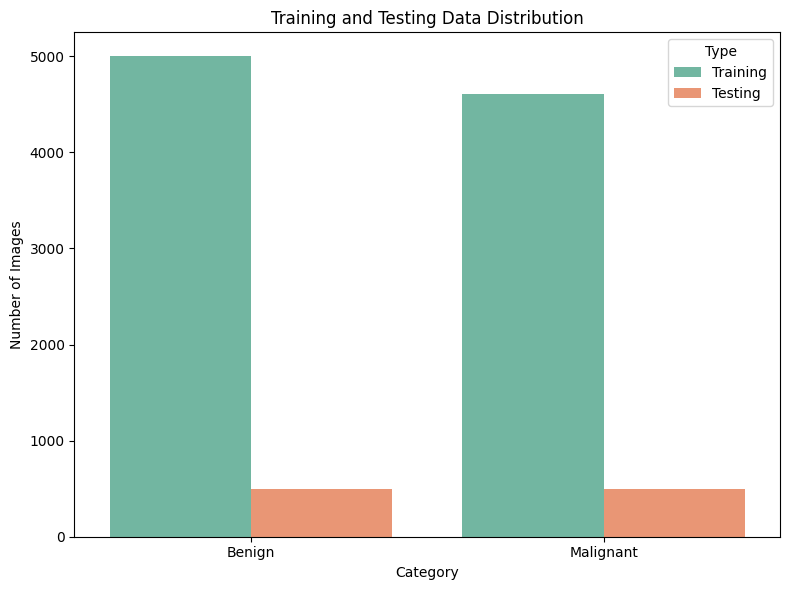

In [8]:
data = pd.DataFrame({
    'Category': ['Benign', 'Malignant', 'Benign', 'Malignant'],
    'Count': [5000, 4605, 500, 500],
    'Type': ['Training', 'Training', 'Testing', 'Testing']
})


plt.figure(figsize=(8, 6))
sns.barplot(data=data, x='Category', y='Count', hue='Type', palette='Set2')

plt.title('Training and Testing Data Distribution')
plt.ylabel('Number of Images')
plt.tight_layout()
plt.show()

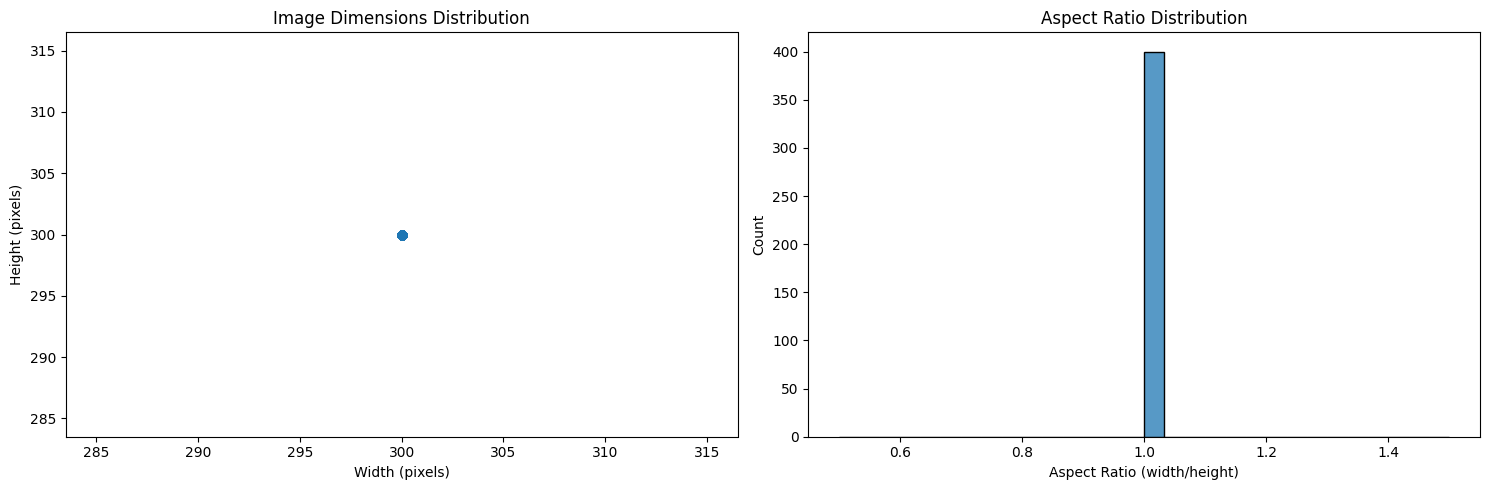

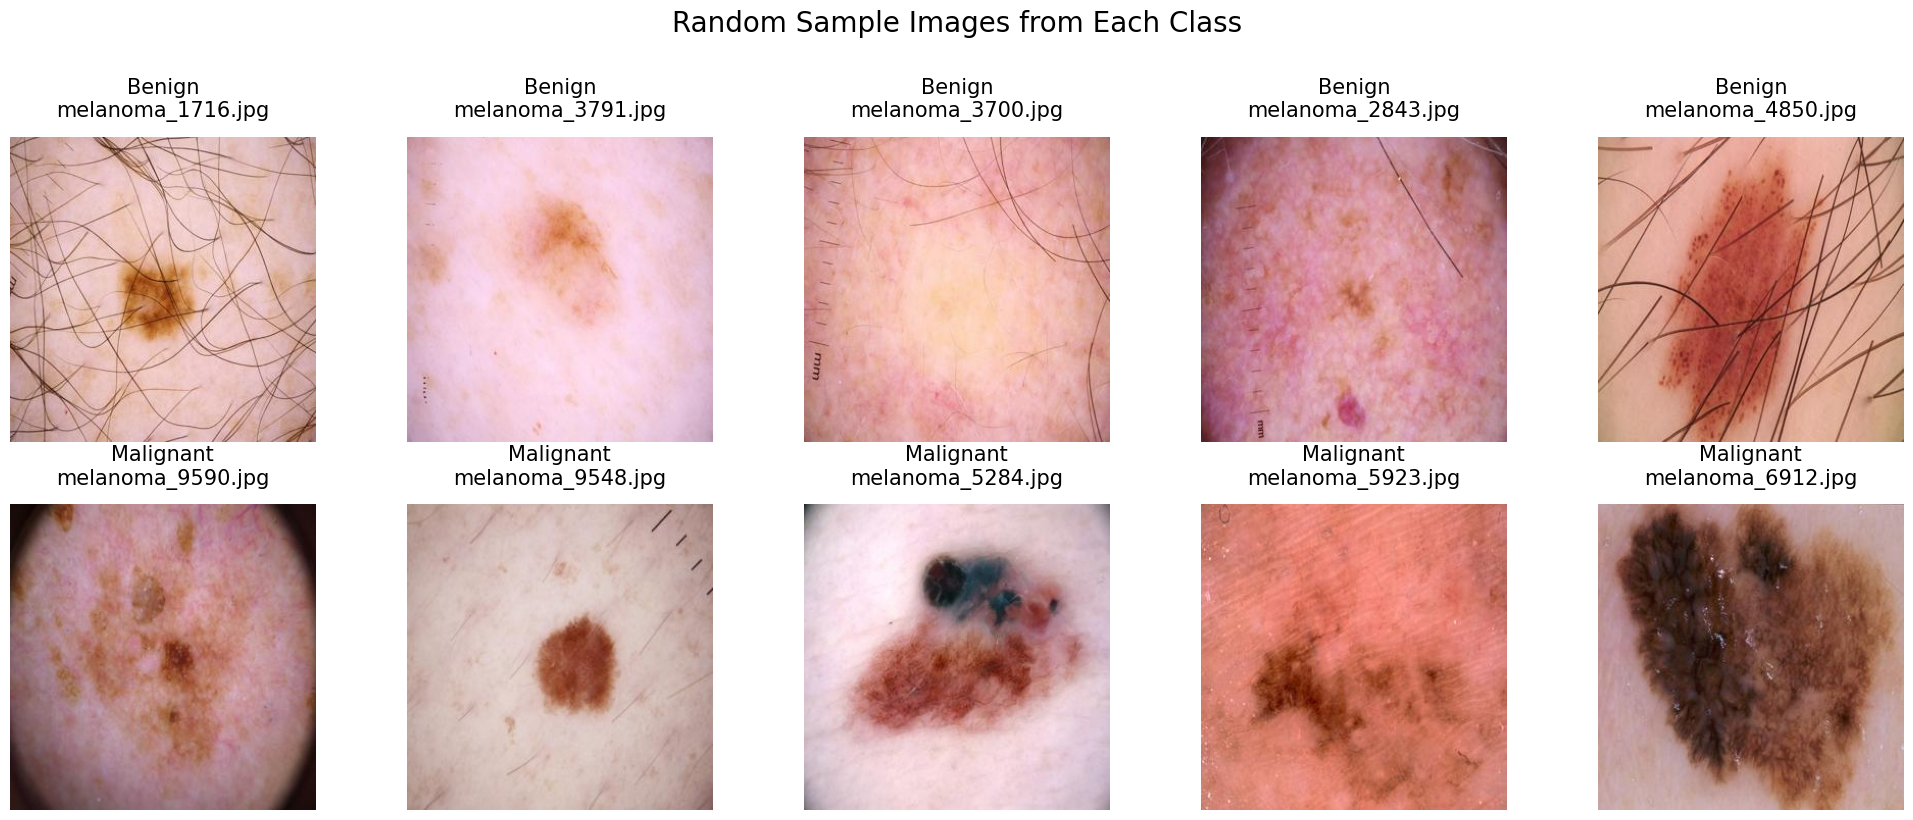

In [9]:
# Plot statistics
plot_image_statistics(image_sizes, aspect_ratios)

# Display sample images
display_sample_images(base_path)

In [10]:
# Directory containing the dataset
input_dir = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset"  # Adjust if needed

# Lists to store image sizes and small images
image_sizes = []

# Supported image extensions
extensions = (".jpg", ".png", ".jpeg", ".JPG", ".PNG", ".JPEG")

# Walk through the directory (handles subfolders)
for root, dirs, files in os.walk(input_dir):
    # print(f"Checking directory: {root}")
    for filename in files:
        if filename.lower().endswith(extensions):
            img_path = os.path.join(root, filename)
            
            # Verify file exists
            if not os.path.exists(img_path):
                print(f"File not found: {img_path}")
                continue
            
            # Read the image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load {filename} from {img_path}")
                continue
            
            # Get dimensions (height, width)
            height, width = img.shape[:2]
            image_sizes.append((height, width))
            
# Summarize all sizes
if not image_sizes:
    print("No valid images found in the directory.")
else:
    size_counts = Counter(image_sizes)
    print(f"Found {len(image_sizes)} images.")
    print("\nImage sizes and their frequencies:")
    for size, count in size_counts.items():
        print(f"Size (HxW): {size[0]}x{size[1]} - {count} images")

print("\nAnalysis complete") 

Found 10605 images.

Image sizes and their frequencies:
Size (HxW): 300x300 - 10605 images

Analysis complete


## Data Splitting

### Combining the data and resplitting them to train, val, and test (75%, 15%, and 10%)

In [11]:
# Starting with combining test and train folders for later splitting into train, val, and test
def combine_data(source_path, target_path):
    """
    Combine train and test folders into a single folder for each class.
    
    Args:
        source_path: Path to the original dataset containing train and test folders
        target_path: Path where the combined dataset will be created
    """
    # Create target directories
    classes = ['benign', 'malignant']
    for class_name in classes:
        os.makedirs(os.path.join(target_path, class_name), exist_ok=True)
    
    # Process each class
    for class_name in classes:
        print(f"\nProcessing {class_name} class...")
        
        # Get paths for train and test folders
        train_path = os.path.join(source_path, 'train', class_name)
        test_path = os.path.join(source_path, 'test', class_name)
        
        # Verify directories exist
        if not os.path.exists(train_path):
            print(f"Warning: Train directory not found: {train_path}")
            continue
        if not os.path.exists(test_path):
            print(f"Warning: Test directory not found: {test_path}")
            continue
        
        # Get all images from both folders
        train_images = [f for f in os.listdir(train_path) 
                       if f.endswith(('.jpg', '.jpeg', '.png'))]
        test_images = [f for f in os.listdir(test_path) 
                      if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Print counts
        print(f"Train images: {len(train_images)}")
        print(f"Test images: {len(test_images)}")
        print(f"Total images: {len(train_images) + len(test_images)}")
        
        # Copy train images
        print(f"\nCopying train images for {class_name}...")
        for img in tqdm(train_images):
            try:
                src_path = os.path.join(train_path, img)
                dst_path = os.path.join(target_path, class_name, img)
                shutil.copy2(src_path, dst_path)
            except Exception as e:
                print(f"Error copying {img}: {str(e)}")
        
        # Copy test images
        print(f"\nCopying test images for {class_name}...")
        for img in tqdm(test_images):
            try:
                src_path = os.path.join(test_path, img)
                dst_path = os.path.join(target_path, class_name, img)
                shutil.copy2(src_path, dst_path)
            except Exception as e:
                print(f"Error copying {img}: {str(e)}")

def verify_combined_data(target_path):
    """Verify the combined dataset by counting images in each class."""
    print("\nVerifying combined dataset:")
    print("-" * 50)
    
    for class_name in ['benign', 'malignant']:
        path = os.path.join(target_path, class_name)
        if os.path.exists(path):
            images = [f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]
            print(f"{class_name.capitalize()}: {len(images)} images")
        else:
            print(f"{class_name.capitalize()}: Directory not found!")
    
    print("-" * 50)

# Define paths
source_path = "/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset"
target_path = "melanoma_cancer_dataset_combined"

# Create target directory if it doesn't exist
os.makedirs(target_path, exist_ok=True)

# Combine the data
combine_data(source_path, target_path)

# Verify the combined dataset
verify_combined_data(target_path)

print("\nData combination completed successfully!")
print(f"Combined dataset created at: {target_path}") 


Processing benign class...
Train images: 5000
Test images: 500
Total images: 5500

Copying train images for benign...


100%|██████████| 5000/5000 [00:05<00:00, 927.55it/s]



Copying test images for benign...


100%|██████████| 500/500 [00:00<00:00, 855.74it/s]



Processing malignant class...
Train images: 4605
Test images: 500
Total images: 5105

Copying train images for malignant...


100%|██████████| 4605/4605 [00:05<00:00, 847.49it/s]



Copying test images for malignant...


100%|██████████| 500/500 [00:00<00:00, 912.32it/s]


Verifying combined dataset:
--------------------------------------------------
Benign: 5500 images
Malignant: 5105 images
--------------------------------------------------

Data combination completed successfully!
Combined dataset created at: melanoma_cancer_dataset_combined


In [13]:
def create_split_directories(base_path):
    
    """ Create the necessary directory structure for the split dataset. """
    
    # Create main directories
    splits = ['train', 'val', 'test']
    classes = ['benign', 'malignant']
    
    # Create all directories
    for split in splits:
        for class_name in classes:
            os.makedirs(os.path.join(base_path, split, class_name), exist_ok=True)

def split_combined_data(source_path, target_path, train_ratio=0.75, val_ratio=0.15, test_ratio=0.10):
    """
    Split the combined dataset into train, validation, and test sets.
    
    Args:
        source_path: Path to the combined dataset
        target_path: Path where the split dataset will be created
        train_ratio: Proportion of data for training (default: 0.75)
        val_ratio: Proportion of data for validation (default: 0.15)
        test_ratio: Proportion of data for testing (default: 0.10)
    """
    # Create directory structure
    create_split_directories(target_path)
    
    # Set random seed for reproducibility
    random.seed(42)
    
    # Store split information for visualization
    split_info = {}
    
    # Process each class
    for class_name in ['benign', 'malignant']:
        print(f"\nProcessing {class_name} class...")
        
        # Get path for the class folder
        class_path = os.path.join(source_path, class_name)
        
        # Verify directory exists
        if not os.path.exists(class_path):
            print(f"Warning: Class directory not found: {class_path}")
            continue
        
        # Get all images
        images = [f for f in os.listdir(class_path) 
                 if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        # Shuffle images
        random.shuffle(images)
        
        # Calculate split sizes
        total_images = len(images)
        train_size = int(total_images * train_ratio)
        val_size = int(total_images * val_ratio)
        
        # Split the data
        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]
        
        # Store split information
        split_info[class_name] = {
            'total': total_images,
            'train': len(train_images),
            'val': len(val_images),
            'test': len(test_images)
        }
        
        # Print split information
        print(f"Total {class_name} images: {total_images}")
        print(f"Train: {len(train_images)} ({len(train_images)/total_images*100:.1f}%)")
        print(f"Validation: {len(val_images)} ({len(val_images)/total_images*100:.1f}%)")
        print(f"Test: {len(test_images)} ({len(test_images)/total_images*100:.1f}%)")
        
        # Copy files to their respective directories
        splits = {
            'train': train_images,
            'val': val_images,
            'test': test_images
        }
        
        for split_name, split_images in splits.items():
            print(f"\nCopying {split_name} images for {class_name}...")
            for img in tqdm(split_images):
                try:
                    src_path = os.path.join(class_path, img)
                    dst_path = os.path.join(target_path, split_name, class_name, img)
                    shutil.copy2(src_path, dst_path)
                except Exception as e:
                    print(f"Error copying {img}: {str(e)}")
    
    return split_info

def visualize_split(split_info, save_path='results/dataset_split_visualization.png'):
    
    """ Visualize the dataset split. """
    
    # Prepare data for plotting
    classes = list(split_info.keys())
    splits = ['train', 'val', 'test']
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Bar chart of split sizes
    x = np.arange(len(classes))
    width = 0.25
    
    for i, split in enumerate(splits):
        values = [split_info[cls][split] for cls in classes]
        ax1.bar(x + i*width, values, width, label=split.capitalize())
    
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Number of Images')
    ax1.set_title('Dataset Split by Class')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels([cls.capitalize() for cls in classes])
    ax1.legend()
    
    # Plot 2: Pie chart of overall split
    total_train = sum(split_info[cls]['train'] for cls in classes)
    total_val = sum(split_info[cls]['val'] for cls in classes)
    total_test = sum(split_info[cls]['test'] for cls in classes)
    
    ax2.pie([total_train, total_val, total_test], 
            labels=['Train', 'Validation', 'Test'],
            autopct='%1.1f%%',
            startangle=90)
    ax2.axis('equal')
    ax2.set_title('Overall Dataset Split')
    
    plt.tight_layout()
    
    # Create directory if it doesn't exist
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.show()
    # plt.savefig(save_path)
    # plt.close()
    
    # print(f"Visualization saved to {save_path}")

def verify_split(target_path):
    
    """ Verify the split by counting images in each directory. """
    
    splits = ['train', 'val', 'test']
    classes = ['benign', 'malignant']
    
    print("Verifying split:")
    print("-" * 50)
    
    for split in splits:
        print(f"\n{split.upper()} SET:")
        for class_name in classes:
            path = os.path.join(target_path, split, class_name)
            if os.path.exists(path):
                images = [f for f in os.listdir(path) if f.endswith(('.jpg', '.jpeg', '.png'))]
                print(f"  {class_name.capitalize()}: {len(images)} images")
            else:
                print(f"  {class_name.capitalize()}: Directory not found!")
    
    print("\n" + "-" * 50)


Processing benign class...
Total benign images: 5500
Train: 4125 (75.0%)
Validation: 825 (15.0%)
Test: 550 (10.0%)

Copying train images for benign...


100%|██████████| 4125/4125 [00:00<00:00, 8693.45it/s]



Copying val images for benign...


100%|██████████| 825/825 [00:00<00:00, 8729.27it/s]



Copying test images for benign...


100%|██████████| 550/550 [00:00<00:00, 8549.21it/s]



Processing malignant class...
Total malignant images: 5105
Train: 3828 (75.0%)
Validation: 765 (15.0%)
Test: 512 (10.0%)

Copying train images for malignant...


100%|██████████| 3828/3828 [00:00<00:00, 8737.23it/s]



Copying val images for malignant...


100%|██████████| 765/765 [00:00<00:00, 8636.16it/s]



Copying test images for malignant...


100%|██████████| 512/512 [00:00<00:00, 8689.48it/s]


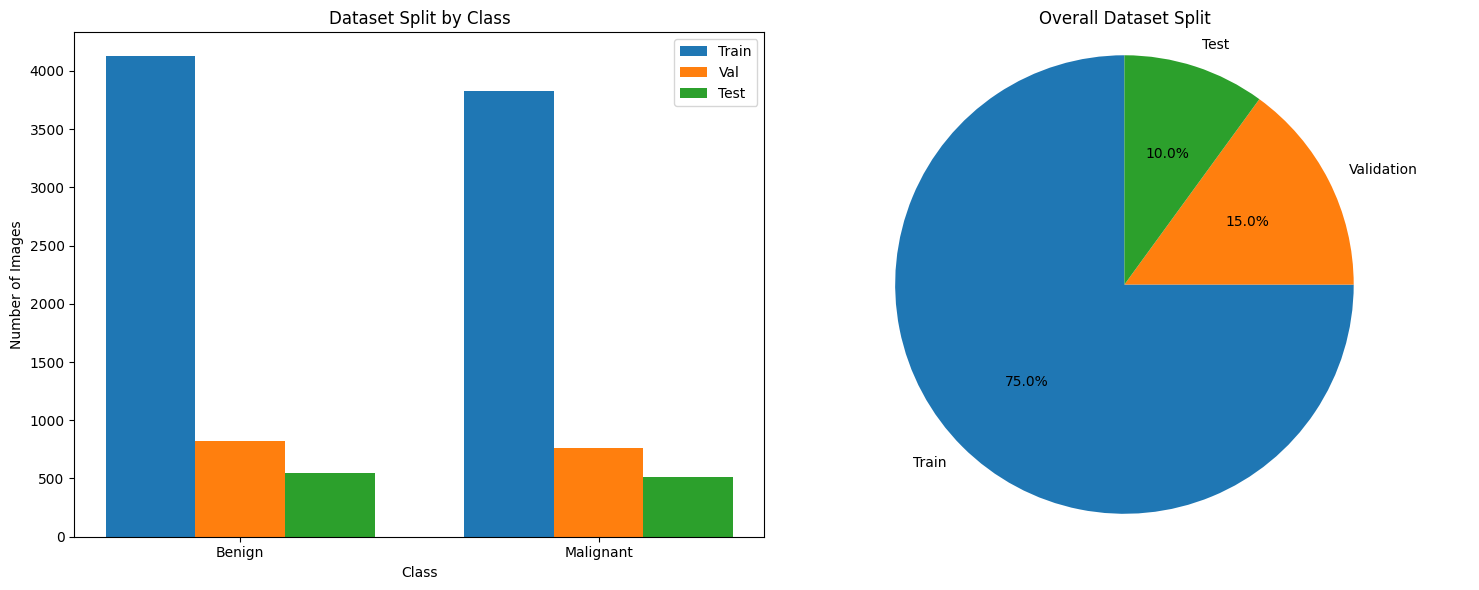

Verifying split:
--------------------------------------------------

TRAIN SET:
  Benign: 4125 images
  Malignant: 3828 images

VAL SET:
  Benign: 825 images
  Malignant: 765 images

TEST SET:
  Benign: 550 images
  Malignant: 512 images

--------------------------------------------------

Dataset split completed successfully!
New dataset structure created at: melanoma_cancer_dataset_split


In [14]:
# Define paths
source_path = "/kaggle/working/melanoma_cancer_dataset_combined"
target_path = "melanoma_cancer_dataset_split"

# Create results directory if it doesn't exist
os.makedirs('results', exist_ok=True)

# Perform the split
split_info = split_combined_data(source_path, target_path)

# Visualize the split
visualize_split(split_info)

# Verify the split
verify_split(target_path)

print("\nDataset split completed successfully!")
print(f"New dataset structure created at: {target_path}")

## Data transformations

In [16]:
# Define data transformations
train_transform = transforms.Compose([
    # transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance of horizontal flip
    transforms.RandomVerticalFlip(p=0.5),    # 50% chance of vertical flip
    transforms.RandomRotation(degrees=15),   # Rotate by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust lighting
    transforms.ToTensor(),  # Convert to tensor (0-1 range, CHW format)
    transforms.Normalize(mean=[0.7164, 0.5676, 0.5455], std=[0.2248, 0.2135, 0.2276])  # After calculating mean & std for the dataset
])

val_transform = transforms.Compose([
    # transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7164, 0.5676, 0.5455], std=[0.2248, 0.2135, 0.2276])
])

test_transform = transforms.Compose([
    # transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7164, 0.5676, 0.5455], std=[0.2248, 0.2135, 0.2276])
])

In [17]:
# Directories
train_dir = "/kaggle/working/melanoma_cancer_dataset_split/train"
val_dir = "/kaggle/working/melanoma_cancer_dataset_split/val"
test_dir = "/kaggle/working/melanoma_cancer_dataset_split/test"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# DataLoader for batching
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check class-to-label mapping
print(train_dataset.class_to_idx)  # Should print a dictionary of class names to label indices

{'benign': 0, 'malignant': 1}


In [18]:
image, label = train_dataset[0]
image.size()

torch.Size([3, 300, 300])

### Visualising some random images to see the augmentation effect

Images in this batch: 32
Image tensor shape: torch.Size([32, 3, 300, 300])


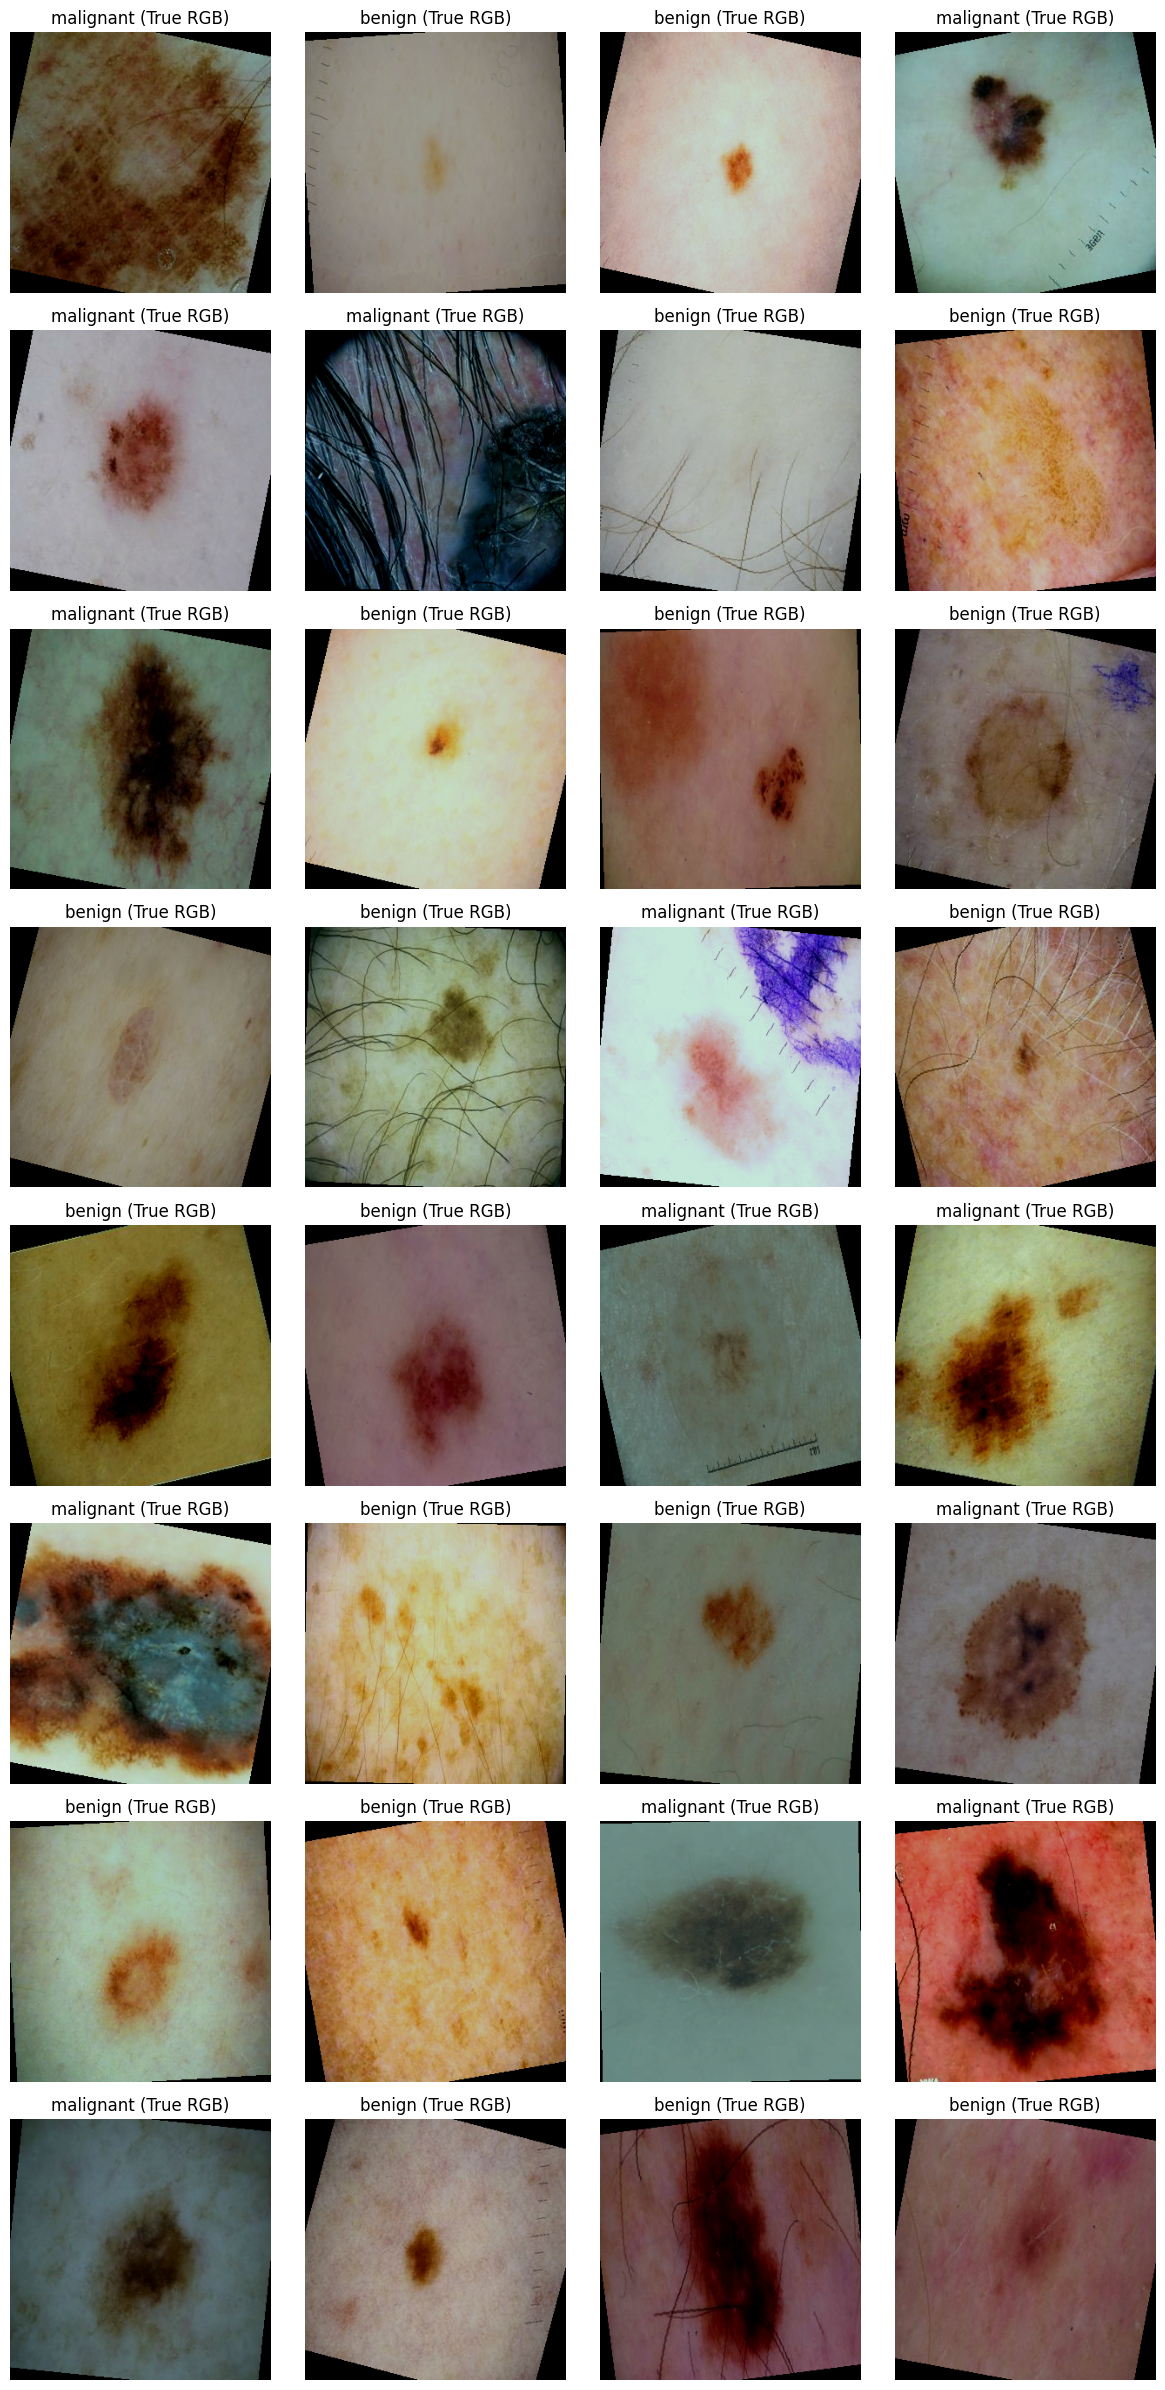

Displayed a random sample of augmented images!


In [19]:
# Class names (subfolder names like Happy, Sad, etc.)
class_names = train_dataset.classes

# Function to convert tensor to numpy for display, handling both grayscale and RGB
def imshow(img, title=None):
    img = img.numpy()  # Convert tensor to numpy
    # Denormalize for visualization (undo ImageNet normalization)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std[:, None, None] + mean[:, None, None]  # Reverse normalization
    img = np.clip(img, 0, 1)  # Ensure values in [0, 1]
    
    if img.shape[0] == 1:  # Grayscale (1 channel)
        img = img.squeeze(0)  # Shape: (224, 224)
        plt.imshow(img, cmap='gray')
        plt.title(f"{title} (Grayscale)")
    elif img.shape[0] == 3:  # RGB (3 channels)
        img = img.transpose((1, 2, 0))  # CHW to HWC: (224, 224, 3)
        plt.imshow(img)
        # Check if all channels are identical (grayscale disguised as RGB)
        if np.allclose(img[:, :, 0], img[:, :, 1]) and np.allclose(img[:, :, 1], img[:, :, 2]):
            plt.title(f"{title} (Grayscale as RGB)")
        else:
            plt.title(f"{title} (True RGB)")
    else:
        raise ValueError(f"Unexpected number of channels: {img.shape[0]}")
    plt.axis('off')

# Get one batch of images
train_iter = iter(train_loader)
images, labels = next(train_iter)

# Adjust batch_size to actual number of images in the batch
actual_batch_size = images.size(0)
print(f"Images in this batch: {actual_batch_size}")
print(f"Image tensor shape: {images.shape}")  # Should be [batch_size, 3, 224, 224]

# Display the images
rows = (actual_batch_size + 3) // 4  # Adjust rows dynamically (ceil division)
cols = min(actual_batch_size, 4)     # Max 4 columns
plt.figure(figsize=(12, 3 * rows))   # Height scales with rows
for i in range(actual_batch_size):
    plt.subplot(rows, cols, i + 1)
    imshow(images[i], title=class_names[labels[i].item()])
plt.tight_layout()
plt.show()

print("Displayed a random sample of augmented images!")

# Model Architecture

In [20]:
# CNN Model from scratch
class MelanomaCNN(nn.Module):
    def __init__(self):
        super(MelanomaCNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)  # the size after conv1 & pool (32, 148, 148)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5)  # the size after conv2 & pool (64, 72, 72)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)  # the size after conv3 & pool (128, 34, 34)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5)  # the size after conv4 & pool (256, 15, 15)
        self.bn4 = nn.BatchNorm2d(256)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # (2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(256* 15* 15, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)

        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))
        x = self.pool(nn.ReLU()(self.bn4(self.conv4(x))))

        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 256* 15* 15)  # based on the output of conv#

        # Fully connected layers
        x = self.dropout(nn.ReLU()(self.fc1(x)))
        x = self.dropout(nn.ReLU()(self.fc2(x)))
        x = self.fc3(x)

        return x

In [21]:
class_counts = Counter(train_dataset.targets)
print("Class distribution:", dict(class_counts))
# Compute class weights for imbalanced dataset
total_samples = sum(class_counts.values())
class_weights = torch.tensor([total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))], dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class distribution: {0: 4125, 1: 3828}
Class weights: tensor([0.9640, 1.0388], device='cuda:0')


In [22]:
model = MelanomaCNN().to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

In [23]:
# Create Models directory
os.makedirs('Models', exist_ok=True)

# Model summary
summary(model, input_size=(batch_size, 3, 300, 300), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
MelanomaCNN                              [32, 2]                   --
├─Conv2d: 1-1                            [32, 32, 296, 296]        2,432
├─BatchNorm2d: 1-2                       [32, 32, 296, 296]        64
├─MaxPool2d: 1-3                         [32, 32, 148, 148]        --
├─Conv2d: 1-4                            [32, 64, 144, 144]        51,264
├─BatchNorm2d: 1-5                       [32, 64, 144, 144]        128
├─MaxPool2d: 1-6                         [32, 64, 72, 72]          --
├─Conv2d: 1-7                            [32, 128, 68, 68]         204,928
├─BatchNorm2d: 1-8                       [32, 128, 68, 68]         256
├─MaxPool2d: 1-9                         [32, 128, 34, 34]         --
├─Conv2d: 1-10                           [32, 256, 30, 30]         819,456
├─BatchNorm2d: 1-11                      [32, 256, 30, 30]         512
├─MaxPool2d: 1-12                        [32, 256, 15, 15]       

## Traning The Model

In [24]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    val_loss = 0
    val_correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Compute validation accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_accuracy = val_correct / total
    val_loss = val_loss / len(val_loader)  # Average validation loss
    return val_loss, val_accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, patience=5):
    # Lists to store metrics for plotting
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')  # Initialize best validation loss to a high value
    epochs_without_improvement = 0  # Counter to track the number of epochs without improvement

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        total_loss = 0  # Accumulating total loss during training
        train_correct = 0  # Track the number of correct predictions
        total = 0  # Total number of samples

        # Initialize the progress bar for the training loop using 'with' statement
        with tqdm(train_loader, unit="batch") as tloader:
            tloader.set_description(f'Epoch [{epoch+1}/{epochs}]')  # Set epoch description
            for batch_idx, (inputs, labels) in enumerate(tloader):
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()  # Zero the gradients
                outputs = model(inputs)
    
                # Compute loss and backpropagate
                loss = criterion(outputs, labels)
                loss.backward()  # Backpropagation
                optimizer.step()  # Update weights

                total_loss += loss.item()

                # Compute training accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                train_correct += (predicted == labels).sum().item()

                # Update the progress bar with the current loss and accuracy
                tloader.set_postfix(loss=f'{total_loss/(batch_idx+1):.4f}', accuracy=f'{train_correct/total:.4f}')

        train_accuracy = train_correct / total  # Compute overall training accuracy
        train_loss = total_loss / len(train_loader)  # Compute average training loss

        # After every epoch, validate the model
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        scheduler.step(val_loss)

        # Store the metrics for plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print epoch results
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, '
              f'Train Acc: {100.*train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, '
              f'Val Acc: {100.*val_accuracy:.2f}%')

        # Early stopping: Save the best model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0  # Reset the counter if improvement is made
            print(f"Validation loss improved to {val_loss:.4f}")
            torch.save(model.state_dict(), "Models/BestModel-03.pth")
        else:
            epochs_without_improvement += 1
            print(f"No improvement in validation loss for {epochs_without_improvement} epoch(s)")

        # Stop training if the validation loss doesn't improve for 'patience' epochs
        if epochs_without_improvement >= patience:
            print(f"Early stopping: validation loss has not improved in {patience} consecutive epochs.")
            break

    # Return the metrics for plotting
    return train_losses, train_accuracies, val_losses, val_accuracies

# Call the train_model function and store the metrics
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader,
                                                                         criterion, optimizer, device, epochs=40)

Epoch [1/40]: 100%|██████████| 249/249 [01:38<00:00,  2.53batch/s, accuracy=0.8096, loss=0.4235]


Epoch 1/40, Train Loss: 0.4235, Train Acc: 80.96%, Val Loss: 0.2915, Val Acc: 87.23%
Validation loss improved to 0.2915


Epoch [2/40]: 100%|██████████| 249/249 [01:44<00:00,  2.39batch/s, accuracy=0.8506, loss=0.3557]


Epoch 2/40, Train Loss: 0.3557, Train Acc: 85.06%, Val Loss: 0.2749, Val Acc: 88.99%
Validation loss improved to 0.2749


Epoch [3/40]: 100%|██████████| 249/249 [01:44<00:00,  2.37batch/s, accuracy=0.8650, loss=0.3201]


Epoch 3/40, Train Loss: 0.3201, Train Acc: 86.50%, Val Loss: 0.2809, Val Acc: 89.81%
No improvement in validation loss for 1 epoch(s)


Epoch [4/40]: 100%|██████████| 249/249 [01:44<00:00,  2.38batch/s, accuracy=0.8785, loss=0.3012]


Epoch 4/40, Train Loss: 0.3012, Train Acc: 87.85%, Val Loss: 0.2646, Val Acc: 89.75%
Validation loss improved to 0.2646


Epoch [5/40]: 100%|██████████| 249/249 [01:44<00:00,  2.38batch/s, accuracy=0.8822, loss=0.2854]


Epoch 5/40, Train Loss: 0.2854, Train Acc: 88.22%, Val Loss: 0.2517, Val Acc: 89.25%
Validation loss improved to 0.2517


Epoch [6/40]: 100%|██████████| 249/249 [01:44<00:00,  2.38batch/s, accuracy=0.8888, loss=0.2830]


Epoch 6/40, Train Loss: 0.2830, Train Acc: 88.88%, Val Loss: 0.2455, Val Acc: 89.81%
Validation loss improved to 0.2455


Epoch [7/40]: 100%|██████████| 249/249 [01:44<00:00,  2.38batch/s, accuracy=0.8969, loss=0.2633]


Epoch 7/40, Train Loss: 0.2633, Train Acc: 89.69%, Val Loss: 0.2437, Val Acc: 90.06%
Validation loss improved to 0.2437


Epoch [8/40]: 100%|██████████| 249/249 [01:44<00:00,  2.38batch/s, accuracy=0.8969, loss=0.2592]


Epoch 8/40, Train Loss: 0.2592, Train Acc: 89.69%, Val Loss: 0.2392, Val Acc: 90.44%
Validation loss improved to 0.2392


Epoch [9/40]: 100%|██████████| 249/249 [01:44<00:00,  2.39batch/s, accuracy=0.8946, loss=0.2590]


Epoch 9/40, Train Loss: 0.2590, Train Acc: 89.46%, Val Loss: 0.2466, Val Acc: 89.43%
No improvement in validation loss for 1 epoch(s)


Epoch [10/40]: 100%|██████████| 249/249 [01:44<00:00,  2.38batch/s, accuracy=0.8973, loss=0.2537]


Epoch 10/40, Train Loss: 0.2537, Train Acc: 89.73%, Val Loss: 0.2432, Val Acc: 88.74%
No improvement in validation loss for 2 epoch(s)


Epoch [11/40]: 100%|██████████| 249/249 [01:44<00:00,  2.37batch/s, accuracy=0.9029, loss=0.2473]


Epoch 11/40, Train Loss: 0.2473, Train Acc: 90.29%, Val Loss: 0.2383, Val Acc: 90.25%
Validation loss improved to 0.2383


Epoch [12/40]: 100%|██████████| 249/249 [01:44<00:00,  2.37batch/s, accuracy=0.9048, loss=0.2400]


Epoch 12/40, Train Loss: 0.2400, Train Acc: 90.48%, Val Loss: 0.2244, Val Acc: 91.07%
Validation loss improved to 0.2244


Epoch [13/40]: 100%|██████████| 249/249 [01:43<00:00,  2.42batch/s, accuracy=0.9048, loss=0.2367]


Epoch 13/40, Train Loss: 0.2367, Train Acc: 90.48%, Val Loss: 0.2212, Val Acc: 90.63%
Validation loss improved to 0.2212


Epoch [14/40]: 100%|██████████| 249/249 [01:43<00:00,  2.41batch/s, accuracy=0.9102, loss=0.2293]


Epoch 14/40, Train Loss: 0.2293, Train Acc: 91.02%, Val Loss: 0.2210, Val Acc: 90.82%
Validation loss improved to 0.2210


Epoch [15/40]: 100%|██████████| 249/249 [01:44<00:00,  2.38batch/s, accuracy=0.9078, loss=0.2284]


Epoch 15/40, Train Loss: 0.2284, Train Acc: 90.78%, Val Loss: 0.2232, Val Acc: 91.01%
No improvement in validation loss for 1 epoch(s)


Epoch [16/40]: 100%|██████████| 249/249 [01:44<00:00,  2.39batch/s, accuracy=0.9114, loss=0.2223]


Epoch 16/40, Train Loss: 0.2223, Train Acc: 91.14%, Val Loss: 0.2562, Val Acc: 89.75%
No improvement in validation loss for 2 epoch(s)


Epoch [17/40]: 100%|██████████| 249/249 [01:44<00:00,  2.38batch/s, accuracy=0.9091, loss=0.2270]


Epoch 17/40, Train Loss: 0.2270, Train Acc: 90.91%, Val Loss: 0.2157, Val Acc: 90.94%
Validation loss improved to 0.2157


Epoch [18/40]: 100%|██████████| 249/249 [01:44<00:00,  2.38batch/s, accuracy=0.9149, loss=0.2190]


Epoch 18/40, Train Loss: 0.2190, Train Acc: 91.49%, Val Loss: 0.2170, Val Acc: 91.07%
No improvement in validation loss for 1 epoch(s)


Epoch [19/40]: 100%|██████████| 249/249 [01:44<00:00,  2.38batch/s, accuracy=0.9111, loss=0.2195]


Epoch 19/40, Train Loss: 0.2195, Train Acc: 91.11%, Val Loss: 0.2049, Val Acc: 91.82%
Validation loss improved to 0.2049


Epoch [20/40]: 100%|██████████| 249/249 [01:44<00:00,  2.38batch/s, accuracy=0.9174, loss=0.2124]


Epoch 20/40, Train Loss: 0.2124, Train Acc: 91.74%, Val Loss: 0.2213, Val Acc: 91.45%
No improvement in validation loss for 1 epoch(s)


Epoch [21/40]: 100%|██████████| 249/249 [01:44<00:00,  2.38batch/s, accuracy=0.9194, loss=0.2064]


Epoch 21/40, Train Loss: 0.2064, Train Acc: 91.94%, Val Loss: 0.2036, Val Acc: 91.13%
Validation loss improved to 0.2036


Epoch [22/40]: 100%|██████████| 249/249 [01:42<00:00,  2.42batch/s, accuracy=0.9189, loss=0.2099]


Epoch 22/40, Train Loss: 0.2099, Train Acc: 91.89%, Val Loss: 0.1989, Val Acc: 92.45%
Validation loss improved to 0.1989


Epoch [23/40]: 100%|██████████| 249/249 [01:43<00:00,  2.41batch/s, accuracy=0.9189, loss=0.2055]


Epoch 23/40, Train Loss: 0.2055, Train Acc: 91.89%, Val Loss: 0.2098, Val Acc: 91.38%
No improvement in validation loss for 1 epoch(s)


Epoch [24/40]: 100%|██████████| 249/249 [01:43<00:00,  2.42batch/s, accuracy=0.9192, loss=0.2007]


Epoch 24/40, Train Loss: 0.2007, Train Acc: 91.92%, Val Loss: 0.2143, Val Acc: 91.01%
No improvement in validation loss for 2 epoch(s)


Epoch [25/40]: 100%|██████████| 249/249 [01:42<00:00,  2.42batch/s, accuracy=0.9189, loss=0.2029]


Epoch 25/40, Train Loss: 0.2029, Train Acc: 91.89%, Val Loss: 0.2027, Val Acc: 91.19%
No improvement in validation loss for 3 epoch(s)


Epoch [26/40]: 100%|██████████| 249/249 [01:42<00:00,  2.42batch/s, accuracy=0.9253, loss=0.1857]


Epoch 26/40, Train Loss: 0.1857, Train Acc: 92.53%, Val Loss: 0.2002, Val Acc: 91.82%
No improvement in validation loss for 4 epoch(s)


Epoch [27/40]: 100%|██████████| 249/249 [01:42<00:00,  2.42batch/s, accuracy=0.9276, loss=0.1814]


Epoch 27/40, Train Loss: 0.1814, Train Acc: 92.76%, Val Loss: 0.1965, Val Acc: 91.95%
Validation loss improved to 0.1965


Epoch [28/40]: 100%|██████████| 249/249 [01:42<00:00,  2.42batch/s, accuracy=0.9266, loss=0.1817]


Epoch 28/40, Train Loss: 0.1817, Train Acc: 92.66%, Val Loss: 0.1953, Val Acc: 91.57%
Validation loss improved to 0.1953


Epoch [29/40]: 100%|██████████| 249/249 [01:43<00:00,  2.41batch/s, accuracy=0.9259, loss=0.1802]


Epoch 29/40, Train Loss: 0.1802, Train Acc: 92.59%, Val Loss: 0.1962, Val Acc: 92.14%
No improvement in validation loss for 1 epoch(s)


Epoch [30/40]: 100%|██████████| 249/249 [01:42<00:00,  2.42batch/s, accuracy=0.9277, loss=0.1793]


Epoch 30/40, Train Loss: 0.1793, Train Acc: 92.77%, Val Loss: 0.1999, Val Acc: 91.76%
No improvement in validation loss for 2 epoch(s)


Epoch [31/40]: 100%|██████████| 249/249 [01:43<00:00,  2.41batch/s, accuracy=0.9287, loss=0.1746]


Epoch 31/40, Train Loss: 0.1746, Train Acc: 92.87%, Val Loss: 0.1913, Val Acc: 92.77%
Validation loss improved to 0.1913


Epoch [32/40]: 100%|██████████| 249/249 [01:42<00:00,  2.42batch/s, accuracy=0.9295, loss=0.1799]


Epoch 32/40, Train Loss: 0.1799, Train Acc: 92.95%, Val Loss: 0.1839, Val Acc: 92.33%
Validation loss improved to 0.1839


Epoch [33/40]: 100%|██████████| 249/249 [01:42<00:00,  2.42batch/s, accuracy=0.9312, loss=0.1757]


Epoch 33/40, Train Loss: 0.1757, Train Acc: 93.12%, Val Loss: 0.1951, Val Acc: 92.39%
No improvement in validation loss for 1 epoch(s)


Epoch [34/40]: 100%|██████████| 249/249 [01:43<00:00,  2.41batch/s, accuracy=0.9310, loss=0.1783]


Epoch 34/40, Train Loss: 0.1783, Train Acc: 93.10%, Val Loss: 0.1974, Val Acc: 92.45%
No improvement in validation loss for 2 epoch(s)


Epoch [35/40]: 100%|██████████| 249/249 [01:42<00:00,  2.43batch/s, accuracy=0.9305, loss=0.1773]


Epoch 35/40, Train Loss: 0.1773, Train Acc: 93.05%, Val Loss: 0.1957, Val Acc: 91.76%
No improvement in validation loss for 3 epoch(s)


Epoch [36/40]: 100%|██████████| 249/249 [01:44<00:00,  2.39batch/s, accuracy=0.9327, loss=0.1662]


Epoch 36/40, Train Loss: 0.1662, Train Acc: 93.27%, Val Loss: 0.1916, Val Acc: 92.20%
No improvement in validation loss for 4 epoch(s)


Epoch [37/40]: 100%|██████████| 249/249 [01:44<00:00,  2.39batch/s, accuracy=0.9384, loss=0.1621]


Epoch 37/40, Train Loss: 0.1621, Train Acc: 93.84%, Val Loss: 0.1905, Val Acc: 92.01%
No improvement in validation loss for 5 epoch(s)
Early stopping: validation loss has not improved in 5 consecutive epochs.


# Testing & Evaluating

In [25]:
# Loading model
model.load_state_dict(torch.load("/kaggle/working/Models/BestModel-03.pth", map_location=device)) # Load the model states (weights)

model.eval()

MelanomaCNN(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=57600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [26]:
# Test Evaluation
correct, total = 0, 0
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.2295, Test Accuracy: 89.55%


### Testing the model on some random images

In [28]:
# Create Performances directory
os.makedirs('Performances', exist_ok=True)

In [29]:
# Define paths
base_path = "/kaggle/working/melanoma_cancer_dataset_split"
test_path = os.path.join(base_path, "test")

# Define the output directory for selected images
output_base_path = "selected_test_images"
os.makedirs(output_base_path, exist_ok=True)

# Supported image extensions
image_extensions = (".jpg", ".jpeg", ".png")

# Function to pick 5 random images from a folder and copy them to a new folder
def copy_random_images(class_folder, output_class_path, num_images=5):
    # Get all images in the class folder (supporting multiple extensions)
    images = []
    for ext in image_extensions:
        images.extend(gb.glob(os.path.join(class_folder, f"*{ext}")))
    
    # Check if there are enough images
    if len(images) < num_images:
        print(f"Warning: Only {len(images)} images found in {class_folder}, cannot pick {num_images} images.")
        return
    
    # Pick 5 random images
    selected_images = random.sample(images, num_images)
    
    # Create the output directory for this class
    os.makedirs(output_class_path, exist_ok=True)
    
    # Copy the selected images to the output directory
    for img_path in selected_images:
        img_name = os.path.basename(img_path)
        output_path = os.path.join(output_class_path, img_name)
        shutil.copy(img_path, output_path)
        print(f"Copied {img_name} to {output_path}")

# Iterate over each class in the test folder
for class_name in os.listdir(test_path):
    class_folder = os.path.join(test_path, class_name)
    
    # Skip if it's not a directory
    if not os.path.isdir(class_folder):
        continue
    
    print(f"\nProcessing class: {class_name}")
    
    # Define the output path for this class
    output_class_path = os.path.join(output_base_path, class_name)
    
    # Copy 5 random images from this class
    copy_random_images(class_folder, output_class_path, num_images=5)

print("\nDone! Selected images have been saved to:", output_base_path)


Processing class: malignant
Copied melanoma_9214.jpg to selected_test_images/malignant/melanoma_9214.jpg
Copied melanoma_6198.jpg to selected_test_images/malignant/melanoma_6198.jpg
Copied melanoma_9479.jpg to selected_test_images/malignant/melanoma_9479.jpg
Copied melanoma_6644.jpg to selected_test_images/malignant/melanoma_6644.jpg
Copied melanoma_6165.jpg to selected_test_images/malignant/melanoma_6165.jpg

Processing class: benign
Copied melanoma_543.jpg to selected_test_images/benign/melanoma_543.jpg
Copied melanoma_2415.jpg to selected_test_images/benign/melanoma_2415.jpg
Copied melanoma_1439.jpg to selected_test_images/benign/melanoma_1439.jpg
Copied melanoma_2672.jpg to selected_test_images/benign/melanoma_2672.jpg
Copied melanoma_9773.jpg to selected_test_images/benign/melanoma_9773.jpg

Done! Selected images have been saved to: selected_test_images


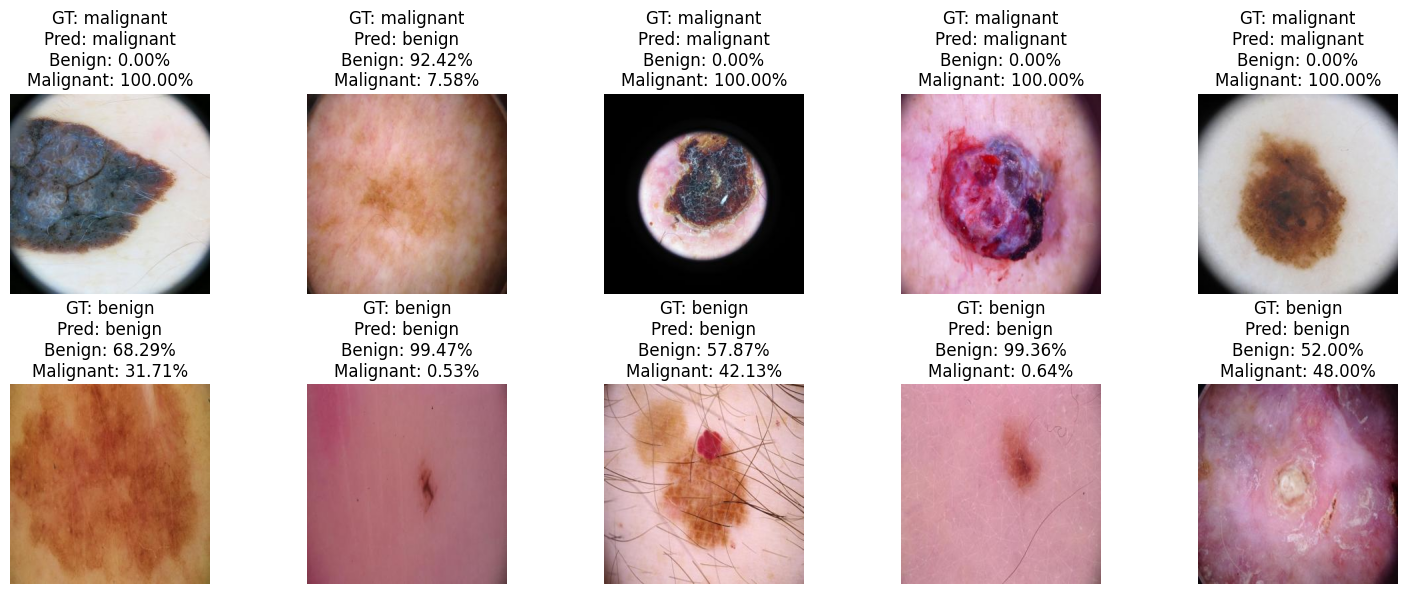

In [30]:
# Define the transform for test images
test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.7164, 0.5676, 0.5455], std=[0.2248, 0.2135, 0.2276])
])

# Class names
class_names = ['benign', 'malignant']

# Function to predict on a single image
def predict_image(image_path, model, transform, device):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_prob, predicted_idx = torch.max(probabilities, 1)
        predicted_class = class_names[predicted_idx.item()]
        probs = probabilities.cpu().numpy()[0]

    return image, predicted_class, probs

# # Test on a single image
# image_path = r"D:\College\Courses\DEPI\Final Project\Melanoma Skin Cancer\Testing\IMG_20250407_042908.jpg"  # Replace with your image path
# image, predicted_class, probs = predict_image(image_path, model, test_transform, device)
# plt.figure(figsize=(6, 6))
# plt.imshow(image)
# plt.title(f"Predicted: {predicted_class}\nBenign: {probs[0]:.2%}, Malignant: {probs[1]:.2%}")
# plt.axis('off')
# plt.show()

# Function to predict on a folder of images
def predict_folder(folder_path, model, transform, device, num_images_to_plot=10):
    image_files = []
    ground_truths = []
    for root, _, files in os.walk(folder_path):
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_files.append(os.path.join(root, f))
                # Extract ground truth from folder name
                folder_name = os.path.basename(root)
                ground_truths.append(folder_name)

    image_files = image_files[:num_images_to_plot]
    ground_truths = ground_truths[:num_images_to_plot]

    num_images = len(image_files)
    cols = 5
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(15, 3 * rows))

    for i, (image_path, gt) in enumerate(zip(image_files, ground_truths)):
        image, predicted_class, probs = predict_image(image_path, model, transform, device)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.title(f"GT: {gt}\nPred: {predicted_class}\nBenign: {probs[0]:.2%}\nMalignant: {probs[1]:.2%}", fontsize=12)
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('Performances/BestModel-03_Prediction.png')
    # plt.close()
    plt.show()

# Test on a folder of images
folder_path = "/kaggle/working/selected_test_images"
predict_folder(folder_path, model, test_transform, device, num_images_to_plot=10)

### Loss and Accuracy

In [31]:
# Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), [100 * acc for acc in train_accuracies], label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), [100 * acc for acc in val_accuracies], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Performances/BestModel-03_Loss&Accuracy.png')
plt.show()

### Confusion Matrix

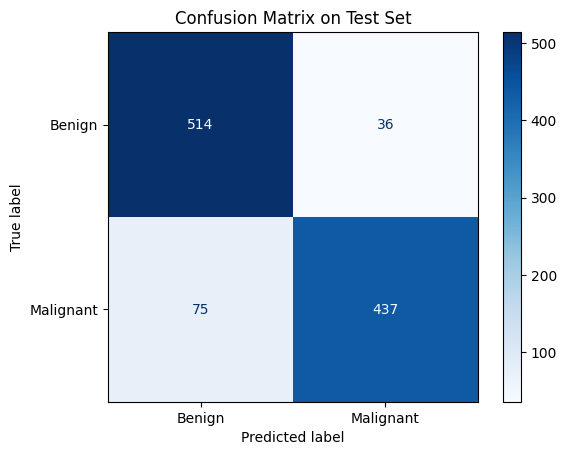

In [32]:
# Confusion Matrix on Test Set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix on Test Set')
plt.savefig('Performances/BestModel-03_CM.png')
plt.show()

### ROC Curve Analysis

In [33]:
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, classification_report

# Get probability scores for the positive class (malignant)
y_scores = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probabilities = torch.softmax(outputs, dim=1)
        y_scores.extend(probabilities[:, 1].cpu().numpy())  # Probability of malignant class

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig('Performances/BestModel-03_ROC.png')
plt.show()


### Error Analysis

In [34]:
def analyze_misclassifications(model, test_loader, class_names, device, num_samples=10):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    misclassified_probs = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            # Find misclassified samples
            incorrect_mask = (predicted != labels)
            if incorrect_mask.sum() > 0:
                misclassified_batch_images = images[incorrect_mask].cpu()
                misclassified_batch_labels = labels[incorrect_mask].cpu()
                misclassified_batch_preds = predicted[incorrect_mask].cpu()
                misclassified_batch_probs = probabilities[incorrect_mask].cpu()
                
                misclassified_images.append(misclassified_batch_images)
                misclassified_labels.append(misclassified_batch_labels)
                misclassified_preds.append(misclassified_batch_preds)
                misclassified_probs.append(misclassified_batch_probs)
    
    # Concatenate all batches
    if misclassified_images:
        misclassified_images = torch.cat(misclassified_images, dim=0)
        misclassified_labels = torch.cat(misclassified_labels, dim=0)
        misclassified_preds = torch.cat(misclassified_preds, dim=0)
        misclassified_probs = torch.cat(misclassified_probs, dim=0)
        
        # Display misclassified images
        n_samples = min(num_samples, len(misclassified_images))
        fig, axes = plt.subplots(2, 5, figsize=(15, 6))
        axes = axes.flatten()
        
        for i in range(n_samples):
            img = misclassified_images[i].permute(1, 2, 0)
            # Denormalize
            mean = torch.tensor([0.7164, 0.5676, 0.5455])
            std = torch.tensor([0.2248, 0.2135, 0.2276])
            img = img * std + mean
            img = img.clamp(0, 1).numpy()
            
            true_label = class_names[misclassified_labels[i]]
            pred_label = class_names[misclassified_preds[i]]
            prob = misclassified_probs[i][misclassified_preds[i]].item()
            
            axes[i].imshow(img)
            axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {prob:.2f}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.savefig('Performances/BestModel-03_Misclassifications.png')
        plt.show()
        
        return {
            'images': misclassified_images,
            'true_labels': misclassified_labels,
            'predicted_labels': misclassified_preds,
            'probabilities': misclassified_probs
        }
    else:
        print("No misclassifications found!")
        return None

# Analyze misclassifications
misclassifications = analyze_misclassifications(model, test_loader, class_names, device)

### Threshold Optimization

In [35]:
def find_optimal_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Calculate J statistic (Youden's J = TPR + TNR - 1 = TPR - FPR)
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_threshold = thresholds[best_idx]
    
    # At this threshold:
    optimal_fpr = fpr[best_idx]
    optimal_tpr = tpr[best_idx]
    
    print(f"Optimal threshold: {best_threshold:.4f}")
    print(f"At optimal threshold - TPR: {optimal_tpr:.4f}, FPR: {optimal_fpr:.4f}")
    
    return best_threshold, optimal_fpr, optimal_tpr

# Find optimal decision threshold
optimal_threshold, opt_fpr, opt_tpr = find_optimal_threshold(all_labels, y_scores)

# Apply optimal threshold
optimized_preds = [1 if score >= optimal_threshold else 0 for score in y_scores]

# Compare with default threshold (0.5)
print("\nMetrics with default threshold (0.5):")
print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))

print("\nMetrics with optimal threshold:")
print(classification_report(all_labels, optimized_preds, target_names=['Benign', 'Malignant']))

Optimal threshold: 0.4348
At optimal threshold - TPR: 0.8809, FPR: 0.0691

Metrics with default threshold (0.5):
              precision    recall  f1-score   support

      Benign       0.87      0.93      0.90       550
   Malignant       0.92      0.85      0.89       512

    accuracy                           0.90      1062
   macro avg       0.90      0.89      0.89      1062
weighted avg       0.90      0.90      0.90      1062


Metrics with optimal threshold:
              precision    recall  f1-score   support

      Benign       0.89      0.93      0.91       550
   Malignant       0.92      0.88      0.90       512

    accuracy                           0.91      1062
   macro avg       0.91      0.91      0.91      1062
weighted avg       0.91      0.91      0.91      1062

